# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Imports & Settings

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
import matplotlib.transforms as mtransforms
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer sentiment, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [3]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [4]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.8770
1980-02-01,66.9,47.9757
1980-03-01,56.5,48.4793
1980-04-01,52.7,47.0662
1980-05-01,51.7,45.6995


## Prepare Data

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [5]:
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12)})
                  .dropna())

### Scaling

Then we scale the transformed data to the [0,1] interval:

In [6]:
df_transformed = df_transformed.apply(minmax_scale)

### Plot original and transformed series

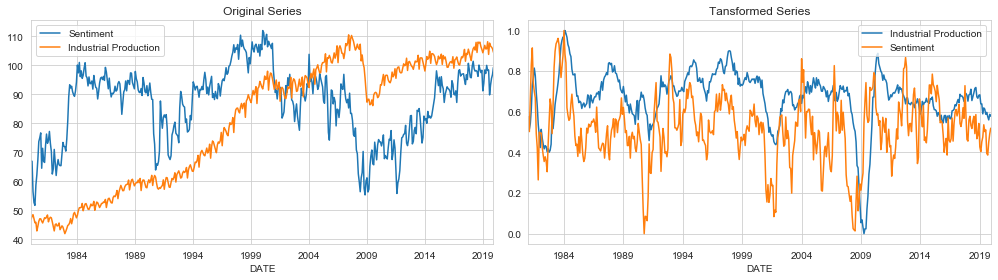

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
fig.tight_layout()
fig.savefig('figures/multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [8]:
df.values.reshape(-1, 12, 2).shape

(40, 12, 2)

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [9]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [10]:
window_size = 18

In [11]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [12]:
X.shape, y.shape

((450, 18, 2), (450, 2))

In [13]:
df_transformed.head()

,ip,sentiment
DATE,,
1981-01-01,0.526669,0.576214
1981-02-01,0.513795,0.502513
1981-03-01,0.542863,0.670017
1981-04-01,0.613397,0.832496
1981-05-01,0.731775,0.914573


Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [14]:
test_size =24
train_size = X.shape[0]-test_size

In [15]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [16]:
X_train.shape, X_test.shape

((426, 18, 2), (24, 18, 2))

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 12 and 6 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [17]:
n_features = output_size = 2

In [18]:
lstm_units = 12
dense_units = 6

In [19]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output')
])

The model has 1,268 parameters, as shown here:

In [20]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 12)                720       
_________________________________________________________________
FC (Dense)                   (None, 6)                 78        
_________________________________________________________________
Output (Dense)               (None, 2)                 14        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [21]:
rnn.compile(loss='mae', optimizer='RMSProp')

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [23]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping],
                 verbose=1)

Train on 426 samples, validate on 24 samples
Epoch 1/100
426/426 [==============================] - 2s 4ms/sample - loss: 0.3102 - val_loss: 0.0599
Epoch 2/100
426/426 [==============================] - 0s 805us/sample - loss: 0.1352 - val_loss: 0.0406
Epoch 3/100
426/426 [==============================] - 0s 761us/sample - loss: 0.1158 - val_loss: 0.0387
Epoch 4/100
426/426 [==============================] - 0s 768us/sample - loss: 0.1131 - val_loss: 0.0390
Epoch 5/100
426/426 [==============================] - 0s 767us/sample - loss: 0.1057 - val_loss: 0.0417
Epoch 6/100
426/426 [==============================] - 0s 757us/sample - loss: 0.1038 - val_loss: 0.0385
Epoch 7/100
426/426 [==============================] - 0s 770us/sample - loss: 0.1008 - val_loss: 0.0396
Epoch 8/100
426/426 [==============================] - 0s 783us/sample - loss: 0.1000 - val_loss: 0.0397
Epoch 9/100
426/426 [==============================] - 0s 772us/sample - loss: 0.0967 - val_loss: 0.0401
Epoch 10/100

## Evaluate the Results

Training stops early after 22 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

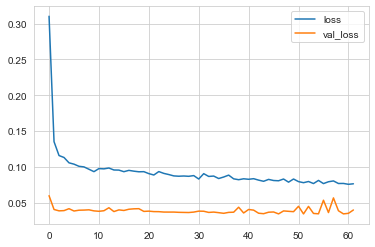

In [24]:
pd.DataFrame(result.history).plot();

In [25]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [26]:
test_mae = mean_absolute_error(y_pred, y_test)

In [27]:
print(test_mae)

0.03439395512202933


In [34]:
y_test.index

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

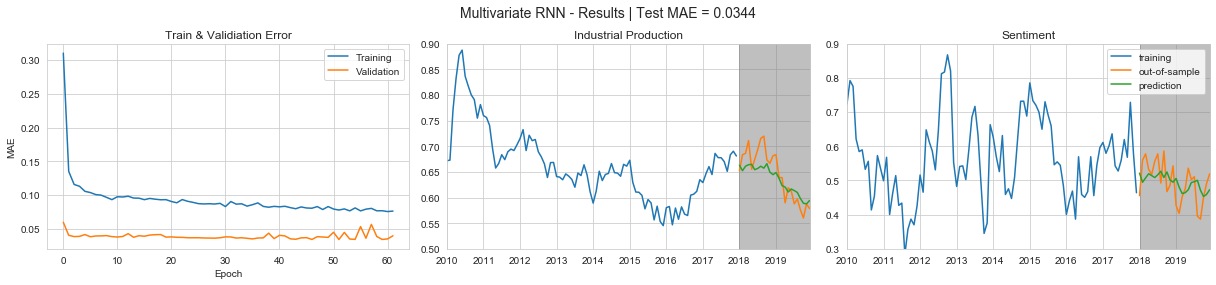

In [41]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 4))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/multivariate_results', dpi=300);